In [26]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import Sequential, Model
from keras.regularizers import l2
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D,Input,concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

# Detect Retina Damage From OCT Images With CNN

## Introduction

Retinal optical coherence tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images take up a significant amount of time (Swanson and Fujimoto, 2017).

Figure 2. Representative Optical Coherence Tomography Images and the Workflow Diagram [Kermany et al., 2018] http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

(A) (Far left) Choroidal neovascularization (CNV) with neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic macular edema (DME) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple drusen (arrowheads) present in early AMD. (Far right) Normal retina with preserved foveal contour and absence of any retinal fluid/edema.

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (NORMAL, CNV, DME, DRUSEN). There are 84,495 X-Ray images (JPEG) and 4 categories (NORMAL, CNV, DME, DRUSEN).

Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

CNV (Choroidal Neovascularization): Choroidal neovascularization refers to the abnormal growth of new blood vessels beneath the retina. This condition is typically associated with diseases like age-related macular degeneration.

DME (Diabetic Macular Edema): Diabetic macular edema is the accumulation of fluid in the macula region of the retina due to diabetic retinopathy. It can lead to vision loss.

DRUSEN: Drusen are small yellowish or whitish deposits seen on the retina. They are considered early signs of diseases like age-related macular degeneration (AMD).

NORMAL: Normal retina images represent healthy retinal cross-sections without any pathological signs or abnormalities.

These terms play a significant role in the diagnosis and monitoring of retinal diseases in medical studies utilizing optical coherence tomography (OCT) imaging technology.


In [27]:
# Main Folder Path
folder_path = "/kaggle/input/kermany2018/OCT2017 "

# Sub Folder Paths
train_dir = f"{folder_path}/train"
val_dir = f"{folder_path}/val"
test_dir = f"{folder_path}/test"

In [28]:
os.listdir(folder_path)

['val', 'test', 'train']

In [29]:
print(f"Train Directory: {os.listdir(train_dir)}")
print(f"Validation Directory: {os.listdir(test_dir)}")
print(f"Test Directory: {os.listdir(val_dir)}")

Train Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Validation Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Test Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']


In [30]:
normal_train_dir = os.path.join(train_dir, "NORMAL")
normal_train_files = os.listdir(normal_train_dir)[:30]

normal_train_files

['NORMAL-2348959-1.jpeg',
 'NORMAL-6581418-5.jpeg',
 'NORMAL-4969570-7.jpeg',
 'NORMAL-8027454-24.jpeg',
 'NORMAL-4034545-3.jpeg',
 'NORMAL-4949902-8.jpeg',
 'NORMAL-5587871-6.jpeg',
 'NORMAL-1149596-1.jpeg',
 'NORMAL-4670089-8.jpeg',
 'NORMAL-5628931-6.jpeg',
 'NORMAL-7984958-6.jpeg',
 'NORMAL-6580495-13.jpeg',
 'NORMAL-4538057-20.jpeg',
 'NORMAL-867217-3.jpeg',
 'NORMAL-9546378-10.jpeg',
 'NORMAL-9453622-6.jpeg',
 'NORMAL-3863241-1.jpeg',
 'NORMAL-8869683-18.jpeg',
 'NORMAL-114740-1.jpeg',
 'NORMAL-2483932-5.jpeg',
 'NORMAL-5535997-2.jpeg',
 'NORMAL-450923-19.jpeg',
 'NORMAL-66861-2.jpeg',
 'NORMAL-33350-20.jpeg',
 'NORMAL-519372-3.jpeg',
 'NORMAL-452201-5.jpeg',
 'NORMAL-9305707-5.jpeg',
 'NORMAL-3049062-6.jpeg',
 'NORMAL-9409941-4.jpeg',
 'NORMAL-2105194-36.jpeg']

In [31]:
normal_train_files[17]

'NORMAL-8869683-18.jpeg'

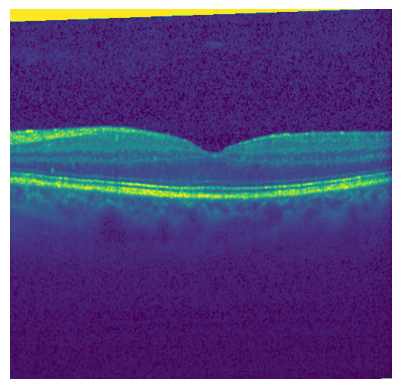

In [32]:
# Image file path
image_file = "NORMAL/NORMAL-8869683-18.jpeg"
image_path = os.path.join(train_dir, image_file)

# Read and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

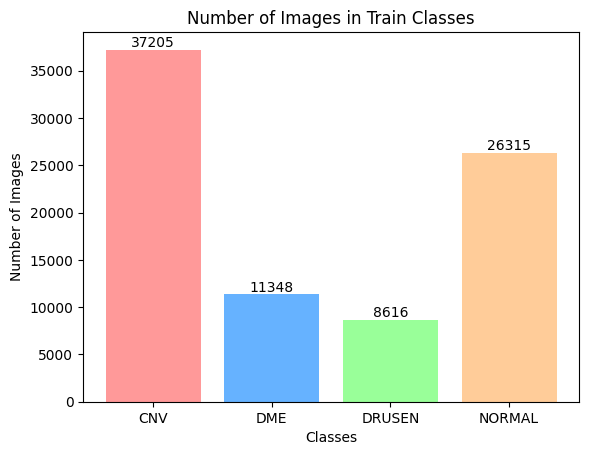

In [33]:
# Specify the directory where the dataset is located
dataset_directory = train_dir

# Create a dictionary to store the counts of images for each class
image_counts = {"CNV": 0, "DME": 0, "DRUSEN": 0, "NORMAL": 0}

# Iterate through the dataset to count the number of images for each class
for class_name in image_counts.keys():
    class_directory = os.path.join(dataset_directory, class_name)
    image_counts[class_name] = len(os.listdir(class_directory))

# Plotting the graph
classes = list(image_counts.keys())
counts = list(image_counts.values())

fig, ax = plt.subplots()
bars = ax.bar(classes, counts, color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])

# Display total counts above the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval), ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Train Classes')
plt.show()

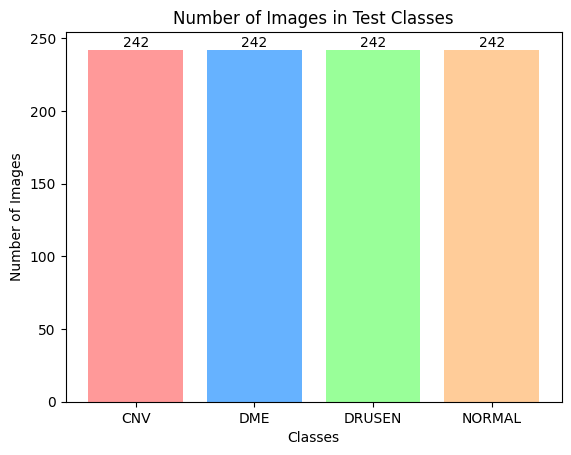

In [34]:

# Specify the directory where the dataset is located
dataset_directory = test_dir

# Create a dictionary to store the counts of images for each class
image_counts = {"CNV": 0, "DME": 0, "DRUSEN": 0, "NORMAL": 0}

# Iterate through the dataset to count the number of images for each class
for class_name in image_counts.keys():
    class_directory = os.path.join(dataset_directory, class_name)
    image_counts[class_name] = len(os.listdir(class_directory))

# Plotting the graph
classes = list(image_counts.keys())
counts = list(image_counts.values())

fig, ax = plt.subplots()
bars = ax.bar(classes, counts, color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])

# Display total counts above the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval), ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Test Classes')
plt.show()

In [35]:
# Specify the directory where the dataset is located
dataset_directory = train_dir

# Specify the classes
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]

# Loop to return the shape of an image from each class
for class_name in classes:
    # Create the class directory
    class_directory = os.path.join(dataset_directory, class_name)

    # Select an image in the class directory
    image = os.listdir(class_directory)[55]

    # Load the image
    image_path = os.path.join(class_directory, image)
    image = cv2.imread(image_path)

    # Print the shape of the image
    print(f"Class: {class_name}, Image Shape: {image.shape}")

Class: CNV, Image Shape: (496, 768, 3)
Class: DME, Image Shape: (512, 512, 3)
Class: DRUSEN, Image Shape: (496, 1536, 3)
Class: NORMAL, Image Shape: (512, 512, 3)


In [36]:
# Specify the directory where the dataset is located
dataset_directory = train_dir

# Specify the classes
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]

# Loop to return the shape of an image from each class
for class_name in classes:
    # Create the class directory
    class_directory = os.path.join(dataset_directory, class_name)

    # Select an image in the class directory
    image = os.listdir(class_directory)[55]

    # Load the image
    image_path = os.path.join(class_directory, image)
    image = cv2.imread(image_path)

    # Print the shape of the image
    print(f"Class: {class_name}, Image Shape: {image.shape}")

    x= []
    y = []

    img = image
    d1,d2,colors = img.shape
    x.append(d1)
    y.append(d2)

print(np.mean(x))
print(np.mean(y))



Class: CNV, Image Shape: (496, 768, 3)
Class: DME, Image Shape: (512, 512, 3)
Class: DRUSEN, Image Shape: (496, 1536, 3)
Class: NORMAL, Image Shape: (512, 512, 3)
512.0
512.0


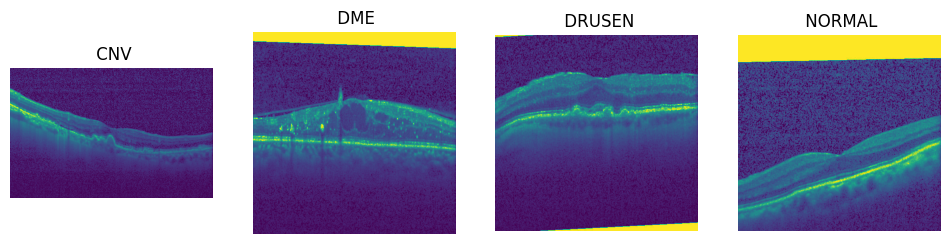

In [37]:

# Specify the classes
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]

# Create a Matplotlib figure and axes
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

# Load and display one example from each class side by side
for i, class_name in enumerate(classes):
    image_path = os.path.join(train_dir, class_name, os.listdir(os.path.join(train_dir, class_name))[0])
    img = imread(image_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f" {class_name}")

plt.show()

# Model 1

## Creating the Model

In [38]:
batch_size = 32

In [39]:
image_shape = (299,299,1)

In [40]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.20, # Shift the pic width by a max of 20%
                               height_shift_range=0.15, # Shift the pic height by a max of 15%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.15, # Shear means cutting away part of the image (max 15%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [41]:
image_gen.flow_from_directory(train_dir)

Found 83484 images belonging to 4 classes.


In [42]:
image_gen.flow_from_directory(test_dir)

Found 968 images belonging to 4 classes.


In [43]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=image_shape, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(4, activation='softmax'))


In [44]:
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 299, 299, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 149, 149, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 149, 149, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 74, 74, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     5,607,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,682,244 (21.68 MB)

 Trainable params: 5,682,244 (21.68 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [48]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=True)

Found 83484 images belonging to 4 classes.


In [49]:
test_image_gen = image_gen.flow_from_directory(test_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=False)

Found 968 images belonging to 4 classes.


In [50]:
results = model.fit(train_image_gen,epochs=10, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/10
   1/2609 ━━━━━━━━━━━━━━━━━━━━ 6:31:07 9s/step - accuracy: 0.4062 - loss: 1.3780

W0000 00:00:1730837819.401169     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.5850 - loss: 1.0010

W0000 00:00:1730838835.558437     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1039s 395ms/step - accuracy: 0.5851 - loss: 1.0010 - val_accuracy: 0.6353 - val_loss: 0.8501
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 727s 278ms/step - accuracy: 0.7740 - loss: 0.6034 - val_accuracy: 0.7831 - val_loss: 0.5430
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 682s 261ms/step - accuracy: 0.8245 - loss: 0.4805 - val_accuracy: 0.9008 - val_loss: 0.2870
Epoch 4/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 682s 261ms/step - accuracy: 0.8495 - loss: 0.4189 - val_accuracy: 0.9132 - val_loss: 0.2758
Epoch 5/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 690s 264ms/step - accuracy: 0.8627 - loss: 0.3819 - val_accuracy: 0.9329 - val_loss: 0.2056
Epoch 6/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 738s 282ms/step - accuracy: 0.8745 - loss: 0.3485 - val_accuracy: 0.9360 - val_loss: 0.2063
Epoch 7/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 707s 270ms/step - accuracy: 0.8862 - loss: 0.3199 - val_accuracy: 0.9267 - val_loss: 0.2118
Epoch 8/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 704s 269ms/step - accuracy: 0.

In [51]:
summary = pd.DataFrame(model.history.history)
summary.head()

accuracy      loss  val_accuracy  val_loss
0  0.683616  0.808110      0.635331  0.850096
1  0.787265  0.571259      0.783058  0.543030
2  0.832112  0.461475      0.900826  0.286961
3  0.852067  0.410152      0.913223  0.275803
4  0.867208  0.370894      0.932851  0.205595

In [52]:
model.history.history

{'accuracy': [0.683616042137146,
  0.7872646450996399,
  0.8321115374565125,
  0.8520674705505371,
  0.8672080636024475,
  0.8788630366325378,
  0.8873676657676697,
  0.8946983814239502,
  0.8988907933235168,
  0.9018734097480774],
 'loss': [0.8081096410751343,
  0.5712592005729675,
  0.4614752233028412,
  0.410152405500412,
  0.3708936870098114,
  0.34110814332962036,
  0.31656935811042786,
  0.29806941747665405,
  0.2857179641723633,
  0.27793481945991516],
 'val_accuracy': [0.6353305578231812,
  0.7830578684806824,
  0.9008264541625977,
  0.913223147392273,
  0.932851254940033,
  0.9359503984451294,
  0.9266529083251953,
  0.9039255976676941,
  0.9504132270812988,
  0.9204545617103577],
 'val_loss': [0.8500959277153015,
  0.5430299639701843,
  0.28696098923683167,
  0.2758033275604248,
  0.20559531450271606,
  0.20627085864543915,
  0.2117956131696701,
  0.23888500034809113,
  0.15023766458034515,
  0.2028156816959381]}

In [53]:
history_df = pd.DataFrame(model.history.history)
history_df.index.name = 'Epoch'
history_df.index += 1  # Epoch numaralarını 1'den başlat

# DataFrame'i yazdır
print(history_df)

       accuracy      loss  val_accuracy  val_loss
Epoch                                            
1      0.683616  0.808110      0.635331  0.850096
2      0.787265  0.571259      0.783058  0.543030
3      0.832112  0.461475      0.900826  0.286961
4      0.852067  0.410152      0.913223  0.275803
5      0.867208  0.370894      0.932851  0.205595
6      0.878863  0.341108      0.935950  0.206271
7      0.887368  0.316569      0.926653  0.211796
8      0.894698  0.298069      0.903926  0.238885
9      0.898891  0.285718      0.950413  0.150238
10     0.901873  0.277935      0.920455  0.202816


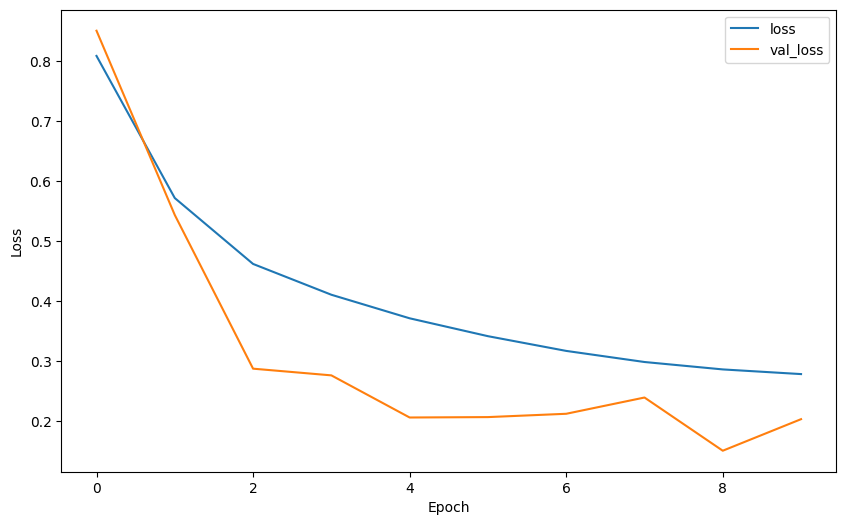

In [54]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

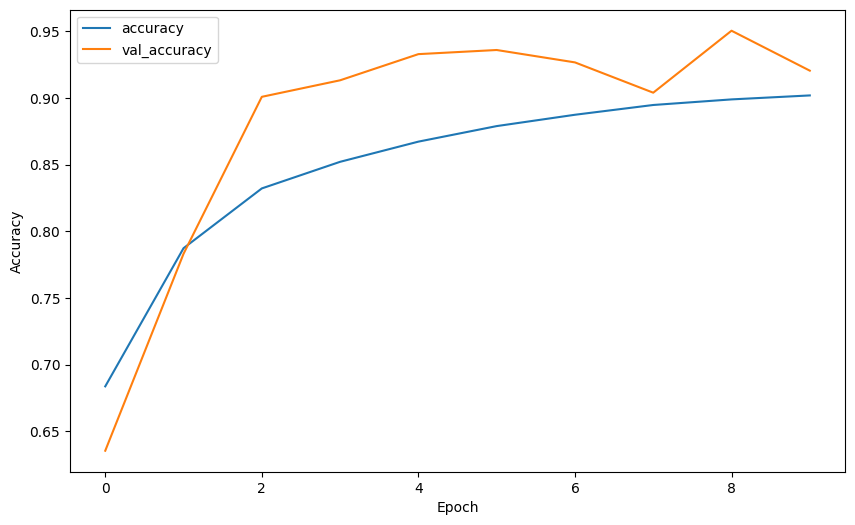

In [55]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [56]:
model.evaluate(test_image_gen)

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step - accuracy: 0.9498 - loss: 0.1263


[0.1939511001110077, 0.9214876294136047]

In [57]:
model.metrics_names

['loss', 'compile_metrics']

In [58]:
pred_probabilities = model.predict(test_image_gen)

 1/31 ━━━━━━━━━━━━━━━━━━━━ 18s 607ms/step

W0000 00:00:1730845146.309508     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step


In [59]:
pred_probabilities

array([[9.9995399e-01, 3.0925883e-05, 1.4081593e-05, 9.6685005e-07],
       [9.8877734e-01, 1.1195402e-02, 2.7100792e-05, 1.9967456e-07],
       [9.9873108e-01, 1.2600671e-03, 7.9922820e-06, 8.9352756e-07],
       ...,
       [1.1548733e-05, 2.1928097e-03, 1.3029750e-03, 9.9649268e-01],
       [6.5395259e-03, 3.3093855e-02, 8.7267803e-03, 9.5163983e-01],
       [2.6274189e-02, 1.7098007e-01, 4.2007495e-02, 7.6073819e-01]],
      dtype=float32)

In [60]:
test_image_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [61]:
predictions = pred_probabilities

In [62]:
predictions_argmax = np.argmax(predictions, axis=1)

print(classification_report(test_image_gen.classes, predictions_argmax))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       242
           1       0.99      0.93      0.96       242
           2       0.99      0.80      0.88       242
           3       0.99      0.99      0.99       242

    accuracy                           0.93       968
   macro avg       0.94      0.93      0.93       968
weighted avg       0.94      0.93      0.93       968



In [63]:
model.save('CNN_model1.h5')

# INCEPTİONV3

In [64]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.20, # Shift the pic width by a max of 20%
                               height_shift_range=0.15, # Shift the pic height by a max of 15%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.15, # Shear means cutting away part of the image (max 15%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )
batch_size = 32

In [65]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=True)

Found 83484 images belonging to 4 classes.


In [66]:
test_image_gen = image_gen.flow_from_directory(test_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=False)

Found 968 images belonging to 4 classes.


In [67]:
# Define input shape
input_shape = (299, 299, 1)  # Grayscale images with shape 299x299

# Create the input layer
inputs = Input(shape=input_shape)

# Convert grayscale to RGB by repeating the single channel across three channels
x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])

# Load the InceptionV3 model with ImageNet weights, without the top layers, and set the input tensor
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=x)

# Flatten the output of the base model
x = Flatten()(base_model.output)

# Fully connected layers
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

# Output layer
outputs = Dense(4, activation='softmax')(x)

# Create the model
InceptionV3_model = Model(inputs=inputs, outputs=outputs)

# Optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile the model
InceptionV3_model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])

# Print the model summary
InceptionV3_model.summary()



Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience = 4)
checkpoint = ModelCheckpoint('InceptionV3_tuning.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')


In [ ]:
InceptionV3_model_results = InceptionV3_model.fit(train_image_gen,epochs=10,
                    validation_data=test_image_gen,
                    callbacks=[early_stop, checkpoint])

In [ ]:
summary = pd.DataFrame(InceptionV3_model.history.history)
summary

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
pred_probabilities = InceptionV3_model.predict(test_image_gen)

In [ ]:
predictions_argmax = np.argmax(pred_probabilities, axis=1)

print(classification_report(test_image_gen.classes, predictions_argmax))

In [ ]:
conf_matrix = confusion_matrix(test_image_gen.classes, predictions_argmax)
print(conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# InceptionV3 Fine-Tuning Model

In [ ]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.20, # Shift the pic width by a max of 20%
                               height_shift_range=0.15, # Shift the pic height by a max of 15%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.15, # Shear means cutting away part of the image (max 15%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )
batch_size = 32

In [ ]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=True)

In [ ]:
test_image_gen = image_gen.flow_from_directory(test_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=False)

In [ ]:
# Define input shape
input_shape = (299, 299, 1)  # Grayscale images with shape 299x299

# Create the input layer
inputs = Input(shape=input_shape)

# Convert grayscale to RGB by repeating the single channel across three channels
x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])

# Load the InceptionV3 model with ImageNet weights, without the top layers, and set the input tensor
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=x)

# Flatten the output of the base model
x = Flatten()(base_model.output)

# Fully connected layers with L2 regularization
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout rate

x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout rate

x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)

# Output layer
outputs = Dense(4, activation='softmax')(x)

# Create the model
InceptionV3_model = Model(inputs=inputs, outputs=outputs)

# Optimizer
optimizer = Adam(learning_rate=1e-5)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

checkpoint = ModelCheckpoint('InceptionV3_tuning.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')


# Compile the model
InceptionV3_model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])

# Print the model summary
InceptionV3_model.summary()

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
InceptionV3_model_results = InceptionV3_model.fit(train_image_gen,epochs=20,
                    validation_data=test_image_gen,
                    callbacks=[early_stopping, checkpoint])

In [ ]:
summary = pd.DataFrame(InceptionV3_model.history.history)
summary

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
pred_probabilities = InceptionV3_model.predict(test_image_gen)

In [ ]:
predictions_argmax = np.argmax(pred_probabilities, axis=1)

print(classification_report(test_image_gen.classes, predictions_argmax))

In [ ]:
conf_matrix = confusion_matrix(test_image_gen.classes, predictions_argmax)
print(conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Dense Net

In [ ]:
 # Import the required libraries

import os
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [ ]:
# Store the base directory path

base_dir = os.path.join("/kaggle/input/kermany2018/oct2017/OCT2017 /")
print('Base directory --> ', os.listdir(base_dir))

In [ ]:
# Store the train, validation and test directory paths

train_dir = os.path.join(base_dir + "train/")
print("Train Directory --> ", os.listdir(train_dir))

validation_dir = os.path.join(base_dir + "val/")
print("Validation Directory --> ", os.listdir(validation_dir))

test_dir = os.path.join(base_dir + "test/")
print("Test Directory --> ", os.listdir(test_dir))

In [ ]:
# Plot each type of image in the dataset

fig, ax = plt.subplots(1, 4, figsize=(15, 10))

drusen = random.choice(os.listdir(train_dir + "DRUSEN"))
drusen_image = load_img(train_dir + "DRUSEN/" + drusen)
ax[0].imshow(drusen_image)
ax[0].set_title("DRUSEN")
ax[0].axis("Off")

dme = random.choice(os.listdir(train_dir + "DME"))
dme_image = load_img(train_dir + "DME/" + dme)
ax[1].imshow(dme_image)
ax[1].set_title("DME")
ax[1].axis("Off")

cnv = random.choice(os.listdir(train_dir + "CNV"))
cnv_image = load_img(train_dir + "CNV/" + cnv)
ax[2].imshow(cnv_image)
ax[2].set_title("CNV")
ax[2].axis("Off")

normal = random.choice(os.listdir(train_dir + "NORMAL"))
normal_image = load_img(train_dir + "NORMAL/" + normal)
ax[3].imshow(normal_image)
ax[3].set_title("NORMAL")
ax[3].axis("Off")

plt.show()

In [ ]:
INPUT_SHAPE = (150, 150, 3)

In [ ]:
from tensorflow.keras.applications import DenseNet121

model = DenseNet121(
    include_top=False,
    weights='/kaggle/input/weights/tensorflow2/default/1/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',
    input_shape=(224, 224, 3),  # Update input shape if needed
    pooling=None,
    classes=1000
)

In [ ]:
from tensorflow.keras.applications import DenseNet121

#  Evaluating Model Performance on Unseen Validation Data


In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = image_gen.flow_from_directory(val_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=False)

In [ ]:
val_gen.reset()
val_probabilities = InceptionV3_model.predict(val_gen)
val_predictions_argmax = np.argmax(val_probabilities, axis=1)

In [ ]:
print(classification_report(val_gen.classes, val_predictions_argmax))